In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import pymc as pm
import pymc_extras.distributions as pmx
import arviz as az
from scipy.stats import genextreme
from datetime import datetime

In [2]:
# Get S&P500 data

data = web.DataReader("^SPX", "stooq", datetime(2021, 1, 1), datetime(2024, 12, 31))
data = data.sort_index()

# Convert S&P data to array

data_array = np.asarray(data)

# Select only closing values

closing_vals = data_array[:, 3]
dates = np.arange(0, np.size(closing_vals))

Text(0.5, 1.0, 'Stationary closing values of S&P500')

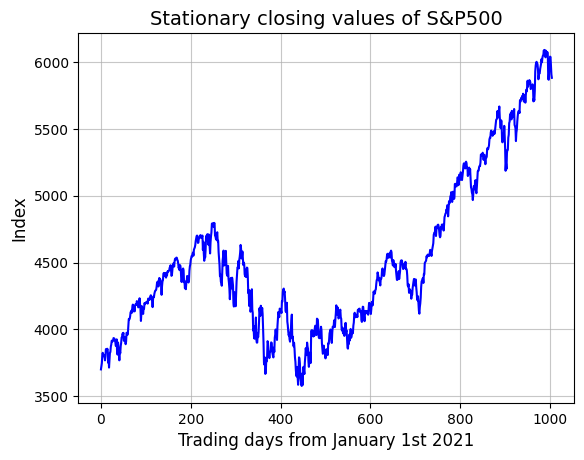

In [3]:
# Plot of non-stationary closing values

plt.plot(dates, closing_vals, color='blue')
plt.grid(True, alpha=0.7)
plt.xlabel('Trading days from January 1st 2021', fontsize=12)
plt.ylabel('Index', fontsize=12)
plt.title('Stationary closing values of S&P500', fontsize=14)

In [4]:
# Transform closing values to stationary ones using log of sucessive returns

stationary_closing_vals = np.array([])

for i in range(1, np.size(closing_vals)):
    log_diff = np.log(closing_vals[i]) - np.log(closing_vals[i-1])
    stationary_closing_vals = np.append(stationary_closing_vals, log_diff)

date_stationary = np.arange(0, np.size(stationary_closing_vals))

Text(0.5, 1.0, 'Stationary closing values of S&P500')

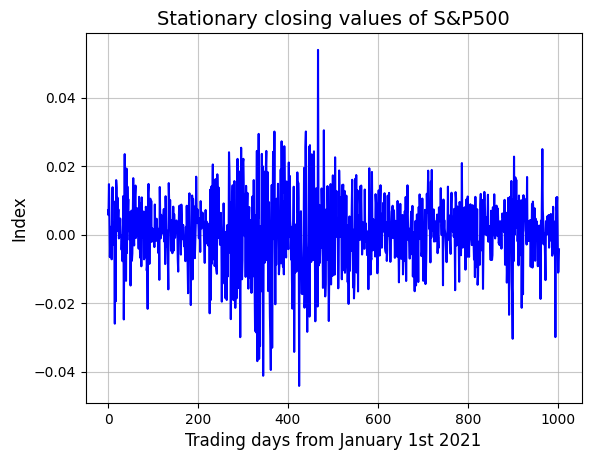

In [5]:
# Plot

plt.plot(date_stationary, stationary_closing_vals, color='blue')
plt.grid(True, alpha=0.7)
plt.xlabel('Trading days from January 1st 2021', fontsize=12)
plt.ylabel('Index', fontsize=12)
plt.title('Stationary closing values of S&P500', fontsize=14)

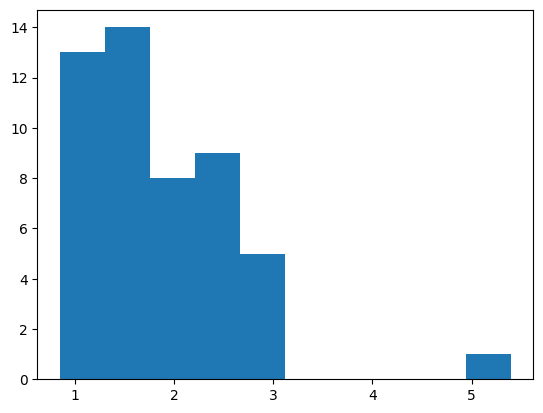

[1.59242691 2.35121301 1.93083638 1.43350385 1.48077552 1.39052011
 1.50488475 0.84876984 0.87690456 1.69191703 0.9781344  2.04955862
 1.76217639 2.40558917 2.53736723 2.21369988 2.9425235  2.44410955
 3.01055371 2.7253558  2.10671549 2.55546288 3.01253409 5.39525043
 3.04785876 2.25838412 1.45924312 1.74095513 1.43333328 1.93771674
 1.44297897 1.21943633 0.98294145 1.4404108  1.17456283 1.86829564
 1.88952828 1.40159871 1.24162779 2.09028917 1.11394974 1.24785886
 1.17780264 0.84677272 1.56700053 2.27811286 1.68342912 0.96427169
 2.49812338 1.09821973]


In [22]:
# Select blockmaxima of 20 entry values 

block_maxima, k = np.array([]), 20
q = np.rint(np.size(stationary_closing_vals)/k).astype(int)
stationary_vals_modq = stationary_closing_vals[:q*k]

for i in range(0, q*k, k):
    chunk = stationary_vals_modq[i:i+20]
    block_maxima = np.append(block_maxima, np.max(chunk))

# Transform by 100

block_maxima = 100 * block_maxima

# Plot a histogram 

plt.hist(block_maxima)
plt.show()

print(block_maxima)

In [12]:
# Bayesin model for GEV

with pm.Model() as model:
    μ = pm.Normal("μ", mu=2, sigma=0.5)
    σ = pm.HalfNormal("σ", sigma=0.5)
    ξ = pm.TruncatedNormal("ξ", mu=0, sigma=0.5, lower=-1, upper=1)

    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=block_maxima)

In [13]:
# Begin sampling 

with model:
    trace = pm.sample(samples=5000, cores=4, chains=4, tune=2000, initvals={"μ": 1.5, "σ": 0.5, "ξ": 0},  target_accept = 0.98)

Initializing NUTS using jitter+adapt_diag...
C:\Users\Philip\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\scalar\basic.py:2253: RuntimeWarning: invalid value encountered in scalar power
  return x**y
C:\Users\Philip\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\scalar\basic.py:3041: RuntimeWarning: invalid value encountered in log1p
  return np.log1p(x)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 378 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


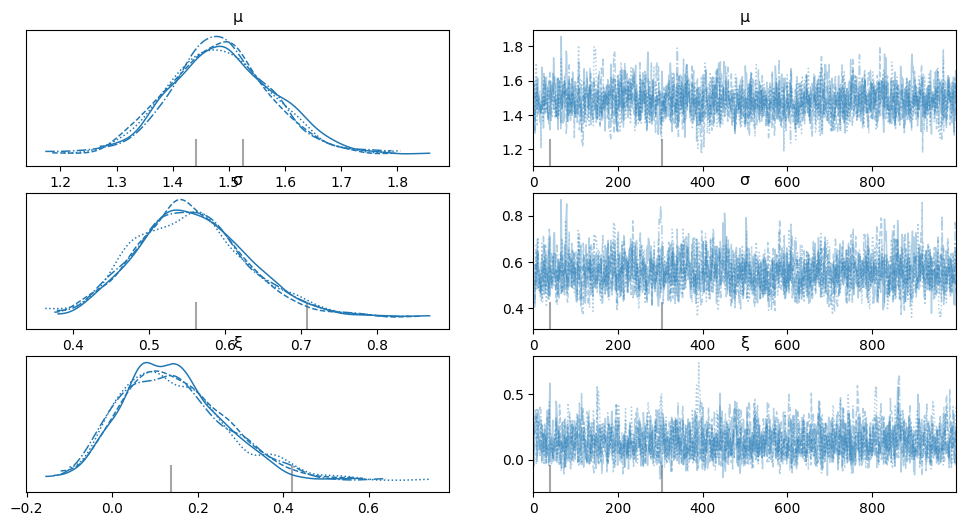

   mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ 1.486 0.090     1.307      1.656      0.002    0.002  1622.000  1828.000   
σ 0.555 0.073     0.421      0.700      0.002    0.001  1497.000  1700.000   
ξ 0.144 0.120    -0.067      0.383      0.003    0.002  1500.000  1486.000   

   r_hat  
μ  1.000  
σ  1.000  
ξ  1.000  


In [19]:
# Plot posterior distributions of mu, sigma and xi

az.plot_trace(trace, var_names=["μ", "σ", "ξ"])
plt.show()

# Get 95% credible intervals 

summary = az.summary(trace, var_names=["μ", "σ", "ξ"], hdi_prob=0.95)
print(summary)

In [57]:
# Comparison of MLE estimates

ξ, μ, σ = genextreme.fit(block_maxima)
print(f'MLE estimates are: μ = {np.round(μ, 3)}, σ = {np.round(σ,3)}, ξ = {-np.round(ξ,3)}')

MLE estimates are: μ = 1.47, σ = 0.527, ξ = 0.127


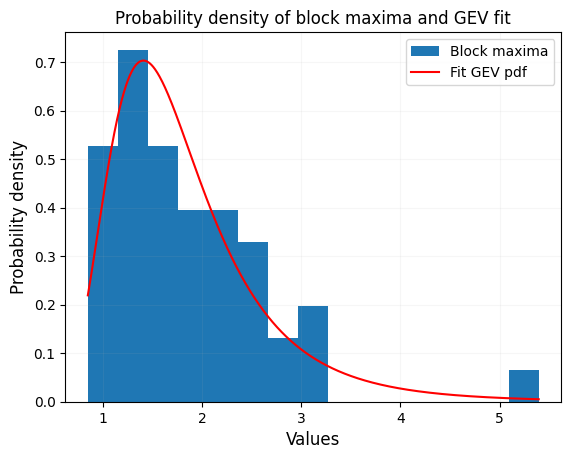

In [106]:
# Plotting of estimated distribution

x = np.linspace(np.min(block_maxima), np.max(block_maxima), 1000)
pdf = genextreme.pdf(x, ξ, loc=μ, scale=σ)

plt.hist(block_maxima, bins=15, density=True, label='Block maxima')
plt.plot(x, pdf, color='red', label='Fit GEV pdf')
plt.title('Probability density of block maxima and GEV fit')
plt.xlabel('Values', fontsize=12)
plt.ylabel('Probability density', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.1)
plt.show()